# DOPP 2020W Exercise 2

## Goal

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually alayse data,
 * use `scikit-learn` to build prediction models.


The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2009-2019)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2019).

The data to be used can be found in the subdirectory named `data`. 

To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import date
from math import sqrt

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

SEED = 1234567

## Task 1: Load Data

### Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- from the `date` column create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date. Use Pandas built-in datetime handling features.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` (make sure to label them accordingly)
- make sure that all columns are appropriately typed
- make sure that you load all the data (2009-2019)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Your resulting data frame should look as follows:

![Weather data frame example](weather_data_dataframe_sample.png)

In [2]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    
    FILES_PATH = Path('./data/weather/')
    weather_files = sorted(FILES_PATH.glob('*.csv'))
    
    # load csv files and add to list
    all_years = []
    for file in weather_files:
        all_years.append(pd.read_csv(file, sep=';'))
    
    # create year, month, week, day column by DataFrame 
    for df in all_years:
        df.date = pd.to_datetime(df.date)
        df['year'] = df.date.dt.year
        df['month'] = df.date.dt.month
        df['week'] = df.date.dt.isocalendar().week
        df['day'] = df.date.dt.day
    
    # create one DataFrame for all years 
    weather_data = pd.concat(all_years)
    # set MultiIndex
    weather_data = weather_data.set_index(['year', 'month', 'week', 'day'])
    
    # as there are strings 'Spuren' in the precip column we replace them with 0.05 
    # the average of 0.0 and the smallest values for precip 0.1
    # also the correct type 'float64' is ensured
    weather_data = weather_data.replace({'precip': {'Spuren': 0.05}}).astype({'precip': 'float64'})
    
    return weather_data

data_weather = load_weather_data()

# check if all years exist in dataframe
assert (data_weather.index.to_frame().year.unique() == [year for year in range(2009, 2020)]).all()

# check if columns correctly typed
assert (data_weather.drop('date', axis=1).dtypes.unique() == [np.dtype('int64'), np.dtype('float64')]).all()

assert data_weather.shape == (4017, 17)

Which combination of year+week has the highest number of entries? What causes this number? (You should find the respective entry/entries using pandas)

Because for example the 2017-01-01 is determined to be in the 52th week of 2016 but in the year 2017 we have 8 values for the 52th week of 2017. This effect only occurs for the first and last week of a year. So for dates that are determined to be in the first or last week of a year but are in another year we have this effect.

In [4]:
# group data by year and week and count number of observations per group
count_by_week = data_weather.groupby(['year', 'week']).count()
# values with the maximum count (use date because they exist for every row)
max_counts = pd.DataFrame(count_by_week[count_by_week.date == count_by_week.date.max()]['date'])
print('Year and week combinations with more than 7 observations:')
print(max_counts)
# closer look at one of the weeks with 8 observations
print()
print('Closer look at year 2017 week 52:')
print(data_weather.xs([2017, 52], level=['year', 'week']).index.to_frame())

Year and week combinations with more than 7 observations:
           date
year week      
2011 52       8
2012 1        8
     52       8
2013 1        8
2014 1        8
2017 52       8
2018 1        8
2019 1        8

Closer look at year 2017 week 52:
           month  day
month day            
1     1        1    1
12    25      12   25
      26      12   26
      27      12   27
      28      12   28
      29      12   29
      30      12   30
      31      12   31


### Influenza infections

Load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- remove rows with missing infection counts
- your resulting data frame should look as follows:

![Example data frame](influenza_data_dataframe_sample.png)

In [6]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    
    DATA_FILE = './data/influenza/influenza.csv'
    
    # load file, missing values encoded with '-'
    influenza_data = pd.read_csv(DATA_FILE, na_values='-')
    # extract week number from 'Kalenderwoche'
    influenza_data['week'] = influenza_data['Kalenderwoche'].transform(
        lambda x: int(x.split('.')[0]))
    # rename relevatn columns
    influenza_data = influenza_data.rename(
        columns={'Neuerkrankungen pro Woche': 'weekly_infections',
                 'Jahr': 'year'})
    # only use relevatn columns
    influenza_data = influenza_data.loc[:,['year', 'week', 'weekly_infections']]
    # drop missing rows
    influenza_data = influenza_data.dropna()
    # set MulitIndex
    influenza_data = influenza_data.set_index(['year', 'week'])
    
    return influenza_data

data_influenza = load_influenza_data()

# check if columns correctly typed
assert data_influenza.index.to_frame().dtypes.unique()[0] == np.dtype('int64')
assert data_influenza.dtypes.values[0] == np.dtype('float64')
assert data_influenza.shape == (258, 1)

Which combination of year+week shows the highest number of infections?

In [8]:
data_influenza[data_influenza.weekly_infections == data_influenza.weekly_infections.max()]

,,weekly_infections
year,week,
2017,1,19700.0


## Task 2: Handling Missing Values

Total number of points for completing this task: **15**

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, you talked to the metereologist that compiled the data. 
She told you that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she says that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

Check the plausibility of these hypotheses in the data, consider the implications, and devise an appropriate strategy to deal with the various missing values.

To implement your strategy, you can use a range of standard mechanisms provided by Pandas, by implementing `handle_missingValues_simple`, or implement a custom strategy (for extra points, by implementing `handle_missingValues_advanced`).

### What values ?
First we check which and how many values are missing in the respective columns.

In [10]:
data_weather.isna().sum()

date                0
skyCover_7h         0
skyCover_14h        0
skyCover_19h        0
temp_7h           198
temp_14h          198
temp_19h          198
temp_dailyMean      0
temp_dailyMax       0
temp_dailyMin       0
hum_7h            198
hum_14h           198
hum_19h           198
windBeauf_7h        0
windBeauf_14h       0
windBeauf_19h       0
precip              0
dtype: int64

## Visualize
Next, we make inspect the missing values visually with a heatmap

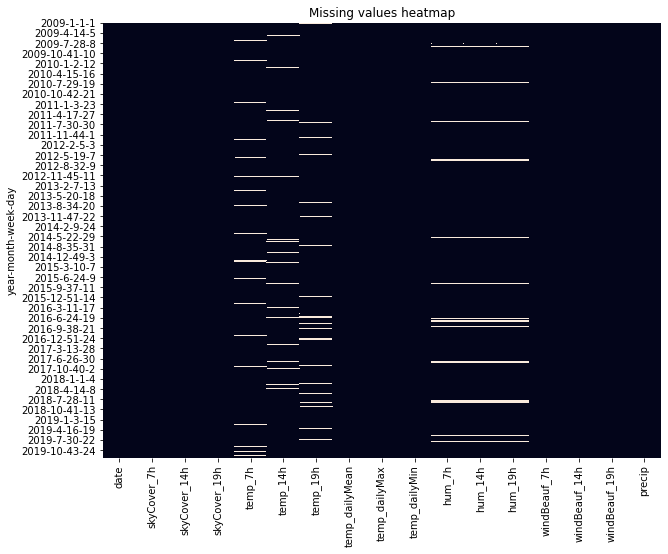

In [11]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Missing values heatmap')
# create heatmap
sns.heatmap(data_weather.isna(), cbar=False)
plt.show()

From the above figure we can see that the temperature values can miss independently of the other temperature values for one day whereas the humidity values are either not missing or missing for the whole day.

To test the assumption of the meteorologist we check the difference in temperature for missing values and the whole dataset.

In [12]:
# difference in temperature means of whole data and missing humidity data
hum_missing = data_weather[data_weather.hum_7h.isna()]
np.abs(data_weather.temp_dailyMean.mean() - hum_missing.temp_dailyMean.mean())

13.15599874774633

As there clearly is a large difference in the temperature for missing values and the whole dataset we further inspect this visually.

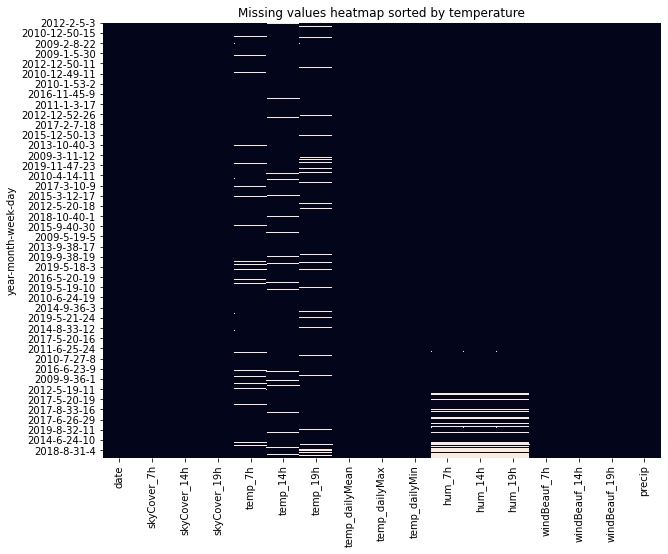

In [13]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Missing values heatmap sorted by temperature')
# create heatmap
sns.heatmap(data_weather.sort_values(by=['temp_dailyMean']).isna(), cbar=False)
plt.show()

We clearly see in the above figure that humidity values are missing mostly for days with higher temperatures. We also see that the missing temperature values have nothing to do with the temperature. Thus, we can only assume that someone forgot to record these values.

Another important fact to know before we decide on a strategy to handle missing values is the correlation between features.

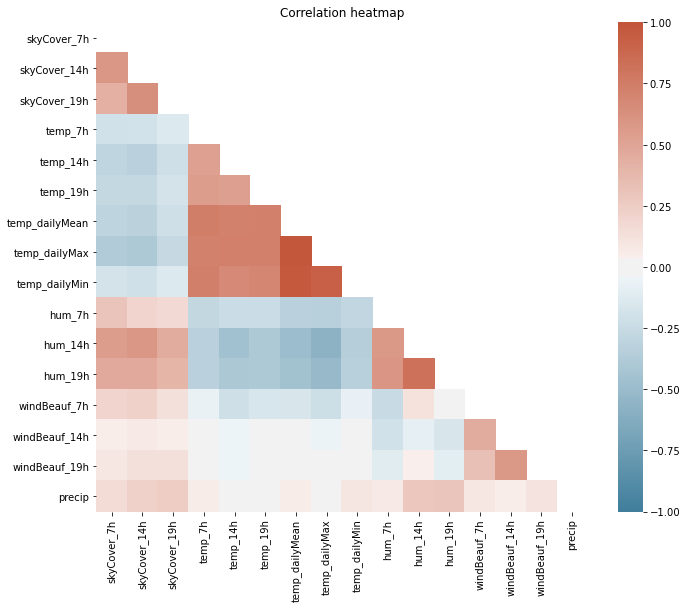

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Compute the correlation matrix
corr = data_weather.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# create heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

In [15]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    
    # impute values with the value in the row before
    complete_data = incomplete_data.fillna(method='ffill')
    
    return complete_data


def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    
    temp_columns = ['temp_7h', 'temp_14h', 'temp_19h']
    
    # linear interploation for temperature columns
    for temp_col in temp_columns:
        incomplete_data[temp_col].interpolate(method='linear', inplace=True)
    
     # fill humidity values besed by interfering them from temperature values
    iter_imputer = IterativeImputer(max_iter=20, random_state=matr_nr)
    imputed_data = iter_imputer.fit_transform(incomplete_data.drop(columns=['date']))
    incomplete_data[['hum_7h', 'hum_14h', 'hum_19h']] = imputed_data[:,9:12]
    
    complete_data = incomplete_data
    
    return complete_data

# simple strategy
data_weather_complete = handle_missingValues_simple(data_weather)

# no missing values
assert not data_weather_complete.isna().values.any()

# check if columns still correctly typed
assert (data_weather_complete.drop('date', axis=1).dtypes.unique()
        ==
        [np.dtype('int64'), np.dtype('float64')]).all()

# check if no rows deleted
assert data_weather_complete.shape == (4017, 17)

# advanced strategy
data_weather_complete = handle_missingValues_advanced(data_weather)

# no missing values
assert not data_weather_complete.isna().values.any()

# check if columns still correctly typed
assert (data_weather_complete.drop('date', axis=1).dtypes.unique()
        ==
        [np.dtype('int64'), np.dtype('float64')]).all()

# check if no rows deleted
assert data_weather_complete.shape == (4017, 17)

###  Discussion

#### Pros and Cons of strategies for dealing with missing data

In the cell provided below, discuss the PROs and CONs of various strategies (row deletion, imputation, hot deck methods etc.) for dealing with missing data. Discuss when it is appropriate to use each method.

### row deletion:
This approach is simple and easy to use and generally save for MCAR and MAR. If only some rows have missing values we do not assume a value like in other strategies. For MNAR deleting rows can introduce bias. Also we lose information which could be used to train a model which is not optimal especially for small datasets.

### simple imputation:
An easy and simple method to use is to replace missing values with some statistic for the feature like mean, median or mode. One major advantage is that we do not reduce the sample size and keep the whole dataset. For MCAR the mean is not biased but for MAR and MNAR we can introduce bias and have an impact on standard errors and variance. For example if we look at time series data and a feature has seasonal differences like temperature imputing with the mean is not a good choice.

### hot-deck methods:
As these methods do not impute with one value like the mean but chooses similar records we can better handle missing values of features with seasonal changes. When we impute from a similar record we increase the risk of increasing bias and potentially draw false conclusions especially if there are a lot of missing values after each other.

### regression methods:
These methods preserve the relationships between features, but we could also introduce implausible values. For example negative values where only positive are possible. Also if features are only correlated weakly regression methods are not able to predict the missing values well.

#### Your chosen strategy <span style="color:blue">

Explain your chosen strategy for dealing with missing values for the various attributes in the cell below.


### simple:
As temperature and humidity values have seasonal fluctuations we use for the simple handling of missing data a forward fill approach. As we saw in the visualization of the missing data we do not have a lot of missing values in a row, but they are scattered over all dates. For this we use the pandas fillna function with method='ffill'. Assuming that temperature values and humidity values do not change drastically from one to another day seems like an appropriate assumption and pandas makes it very easy to use this kind of method.

### advanced:
For the advanced method of handling missing values we went one step further for the handling of the missing temperature values by not using the value of the day before but the average of the day before and the next day. This is implemented by using pandas interpolate function with method='linear'. 

As we can also see in the correlation heatmap humidity values are negatively correlated with the other weather features. Thus, we assume that the humidity values can reasonably be imputed by a regression method. We implemented this approach by using sklearns IterativeImputer which uses by default a BayesianRidge estimator.

Why there are exactly the same number of missing values for all temperature values (198) which is the same for humidity values although the values are not missing for the same days could not be discovered, so we have to assume this is by chance.

## Task 3: Handling Outliers

If you take a closer look at some of the observations, you should notice that some of the temperature values are not particularly plausible (hint: plotting histograms of the distributions helps). Hypothesize on the nature of these outliers and implement a strategy to handle them.

First we have a look at the statistics of our temperature values if they are plausible.

In [19]:
temp_columns = ['temp_7h', 'temp_14h', 'temp_19h']
temp_stats = ['temp_dailyMean', 'temp_dailyMax', 'temp_dailyMin']
data_weather_complete[temp_columns + temp_stats].describe()

,temp_7h,temp_14h,temp_19h,temp_dailyMean,temp_dailyMax,temp_dailyMin
count,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000
mean,10.847448,16.103958,13.551282,11.986931,16.046602,7.886084
std,11.682958,13.847911,12.772218,8.371766,9.751117,7.279185
min,-45.200000,-40.000000,-40.000000,-11.500000,-8.300000,-15.000000
25%,3.600000,7.300000,5.300000,5.400000,8.200000,2.300000
50%,10.200000,15.500000,12.900000,12.300000,16.500000,8.200000
75%,16.900000,23.200000,19.800000,18.800000,24.000000,13.900000
max,104.400000,140.400000,127.200000,30.100000,38.500000,25.300000


We can directly see that although the mean and standard deviation could be plausible the minimum and maximum is not plausible for the 7h, 14h and 19h columns. This description tells further that we do not have the same problem for the dailyMean, dailyMax and dailyMin columns where the minimum and maximum seem reasonable.

To make this more visible we have a look at some boxplots.

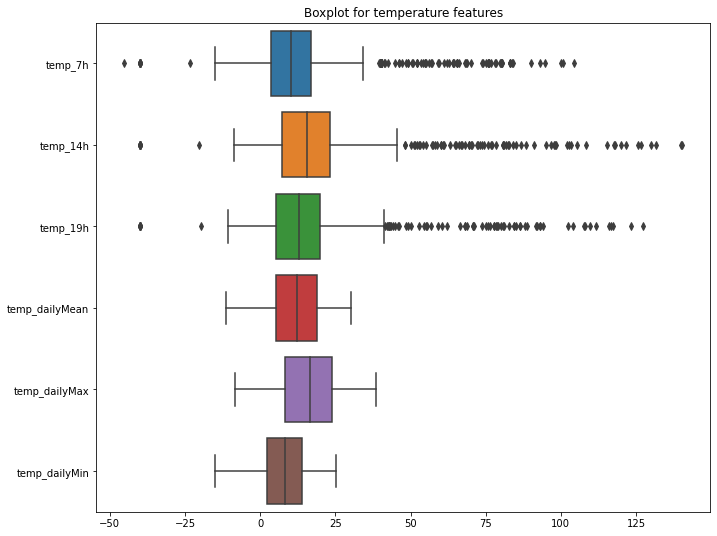

In [20]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Boxplot for temperature features')
# create boxplots
sns.boxplot(data=data_weather_complete[temp_columns + temp_stats], orient='h')
plt.show()

In the above boxplots we clearly see the outliers for the 7h, 17h and 19h columns.

In [21]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    
    # set columns where to remove outliers
    temp_cols = ['temp_7h', 'temp_14h', 'temp_19h']

    # function to detect outliers and set the values to NAN
    # we check if the value is between the dailyMin and dailyMax temperature
    def outlier(row, col):
        if row[col] < row.temp_dailyMin or row[col] > row.temp_dailyMax:
            return np.nan
        else:
            return row[col]
    
    # apply removing of outliers to all temp columns
    for col in temp_cols:
        noisy_data[col] = noisy_data.apply(outlier, axis=1, col=col)

    # imupte missing values with linear interpolation
    cleaned_data = noisy_data.interpolate(method='linear')
    
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

# no missing values
assert not data_weather_cleaned.isna().values.any()

# check if columns still correctly typed
assert (data_weather_cleaned.drop('date', axis=1).dtypes.unique()
        ==
        [np.dtype('int64'), np.dtype('float64')]).all()

# check shape
assert data_weather_cleaned.shape == (4017, 17)

# using z-scores to check for outliers
num_outlier = 0
level = 3 # level for z-score
# calculate values wher z-socre > level and count them
df = data_weather_cleaned.copy()
for temp_col in temp_columns:
    df['outlier'] = np.abs(stats.zscore(df[temp_col])) > 3
    num_outlier += df[df.outlier].shape[0]
# check for not more then 5 outliers
assert num_outlier < 5

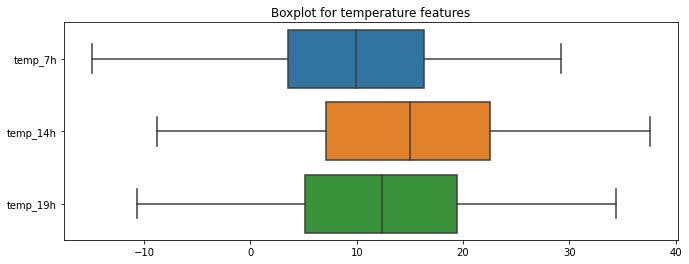

In [22]:
# visually inspect if outliers removed 

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 4))
ax.set_title('Boxplot for temperature features')
# create boxplots
sns.boxplot(data=data_weather_cleaned[temp_columns], orient='h')
plt.show()

#### Your chosen strategy

In the cell below, explain your chosen strategy for dealing with outliers.


The first approach was to use z-scores to check if a temperature is an outlier or not but I found out quickly that this is somewhat flawed because 40 degrees could be a reasonable temperature in the summer but not in the winter. 

Further I performed some checks if Fahrenheit was used for the temperature but as there are also unreasonable negative temperatures this could not be the case.

After figuring out that the dailyMax and dailyMin values are more robust and do not have outliers I decided to simply check if a temperature value is between the dailyMin and dailyMax value. Otherwise, it is replaced with NAN.

At the end I use the same strategy for imputing missing values as before. The pandas interpolate function is used with method linear which leads to reasonable results.

Last, the values get checked again by then using z-sores.

## Task 4: Aggregate values

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: <span style="color:red">max</span> of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

_Additional note: Attentive data scientists might have noticed a problem with isocalendars when aggregating on `year` and `week`. You can ignore this for the purpose of this lecture. In real-world settings you might consider addressing this issue, depending on your task and data_

In [26]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    
    # compute mean humidity values
    data['hum_dailyMean'] = data[['hum_7h', 'hum_14h', 'hum_19h']].mean(axis=1)
    
    # group data and aggreagte values
    weekly_weather_data = data.groupby(level=['year', 'week']).agg(
        temp_weeklyMin=('temp_dailyMin', 'min'),
        temp_weeklyMax=('temp_dailyMax', 'max'),
        temp_weeklyMean=('temp_dailyMean', 'mean'),
        temp_7h_weeklyMedian=('temp_7h', 'median'),
        temp_14h_weeklyMedian=('temp_14h', 'median'),
        temp_19h_weeklyMedian=('temp_19h', 'median'),
        hum_weeklyMean=('hum_dailyMean', 'mean'),
        hum_7h_weeklyMedian=('hum_7h', 'median'),
        hum_14h_weeklyMedian=('hum_14h', 'median'),
        hum_19h_weeklyMedian=('hum_19h', 'median'),
        precip_weeklyMean=('precip', 'mean'),
        windBeauf_14h_weeklyMedian=('windBeauf_14h', 'median'),
    )
    
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

# check for shape number of columns
assert data_weather_weekly.shape[1] == 12

# ceck correctly typed
assert data_weather_weekly.dtypes.values[0] == np.dtype('float64')

## Task 5: Merge influenza and weather datasets

Merge the `data_weather_weekly` and `data_influenza` datasets.

In [29]:
def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    
    # left join on influenza data
    merged_data = influenza_df.merge(weather_df, how='left', left_index=True, right_index=True)

    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)

# no values lost during merge
assert data_merged.shape == (data_influenza.shape[0], 
                             data_influenza.shape[1] + data_weather_weekly.shape[1])

# ceck correctly typed
assert data_merged.dtypes.values[0] == np.dtype('float64')

## Task 6: Visualization

To get a better understanding of the dataset, create visualizations of the merged data set that help to explore the potential relationships between the variables before starting to develop a model.


**Note:** Hand in multiple figures, use a proper naming configuration for the image files. Your plots should present information clearly (i.e. include titles, axis labels, legends,.. -> http://imgs.xkcd.com/comics/convincing.png). You should also describe which insights you gained from the figures.

We are interested in the correlation between the target variable and all other features. We explore this first with a correlation heatmap.

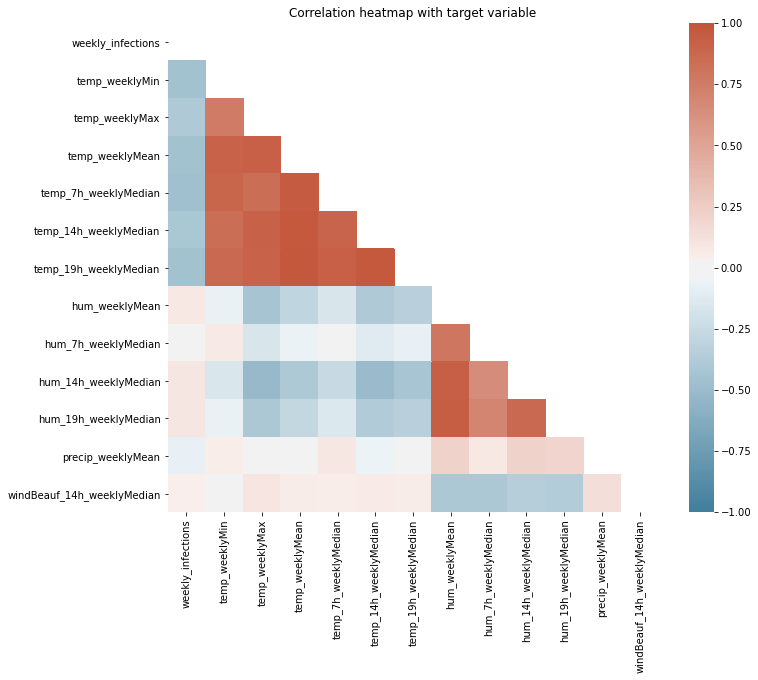

In [30]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap with target variable')

# Compute the correlation matrix
corr = data_merged.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# create heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

In [31]:
# detailed look at correlation with target
corr.weekly_infections

weekly_infections             1.000000
temp_weeklyMin               -0.447928
temp_weeklyMax               -0.387857
temp_weeklyMean              -0.451288
temp_7h_weeklyMedian         -0.464534
temp_14h_weeklyMedian        -0.408644
temp_19h_weeklyMedian        -0.452419
hum_weeklyMean                0.084725
hum_7h_weeklyMedian           0.025076
hum_14h_weeklyMedian          0.096357
hum_19h_weeklyMedian          0.095404
precip_weeklyMean            -0.072371
windBeauf_14h_weeklyMedian    0.039756
Name: weekly_infections, dtype: float64

We see in the above plot that the correlation with the target variable is rather small. Only the temperature values have a negative correlation with the target. Of course temperature values are highly correlated with other temperature values. The same is true for humidity values.

To get a better understanding of the correlations with the target variable and between the features we have a closer look by using a pairplot.

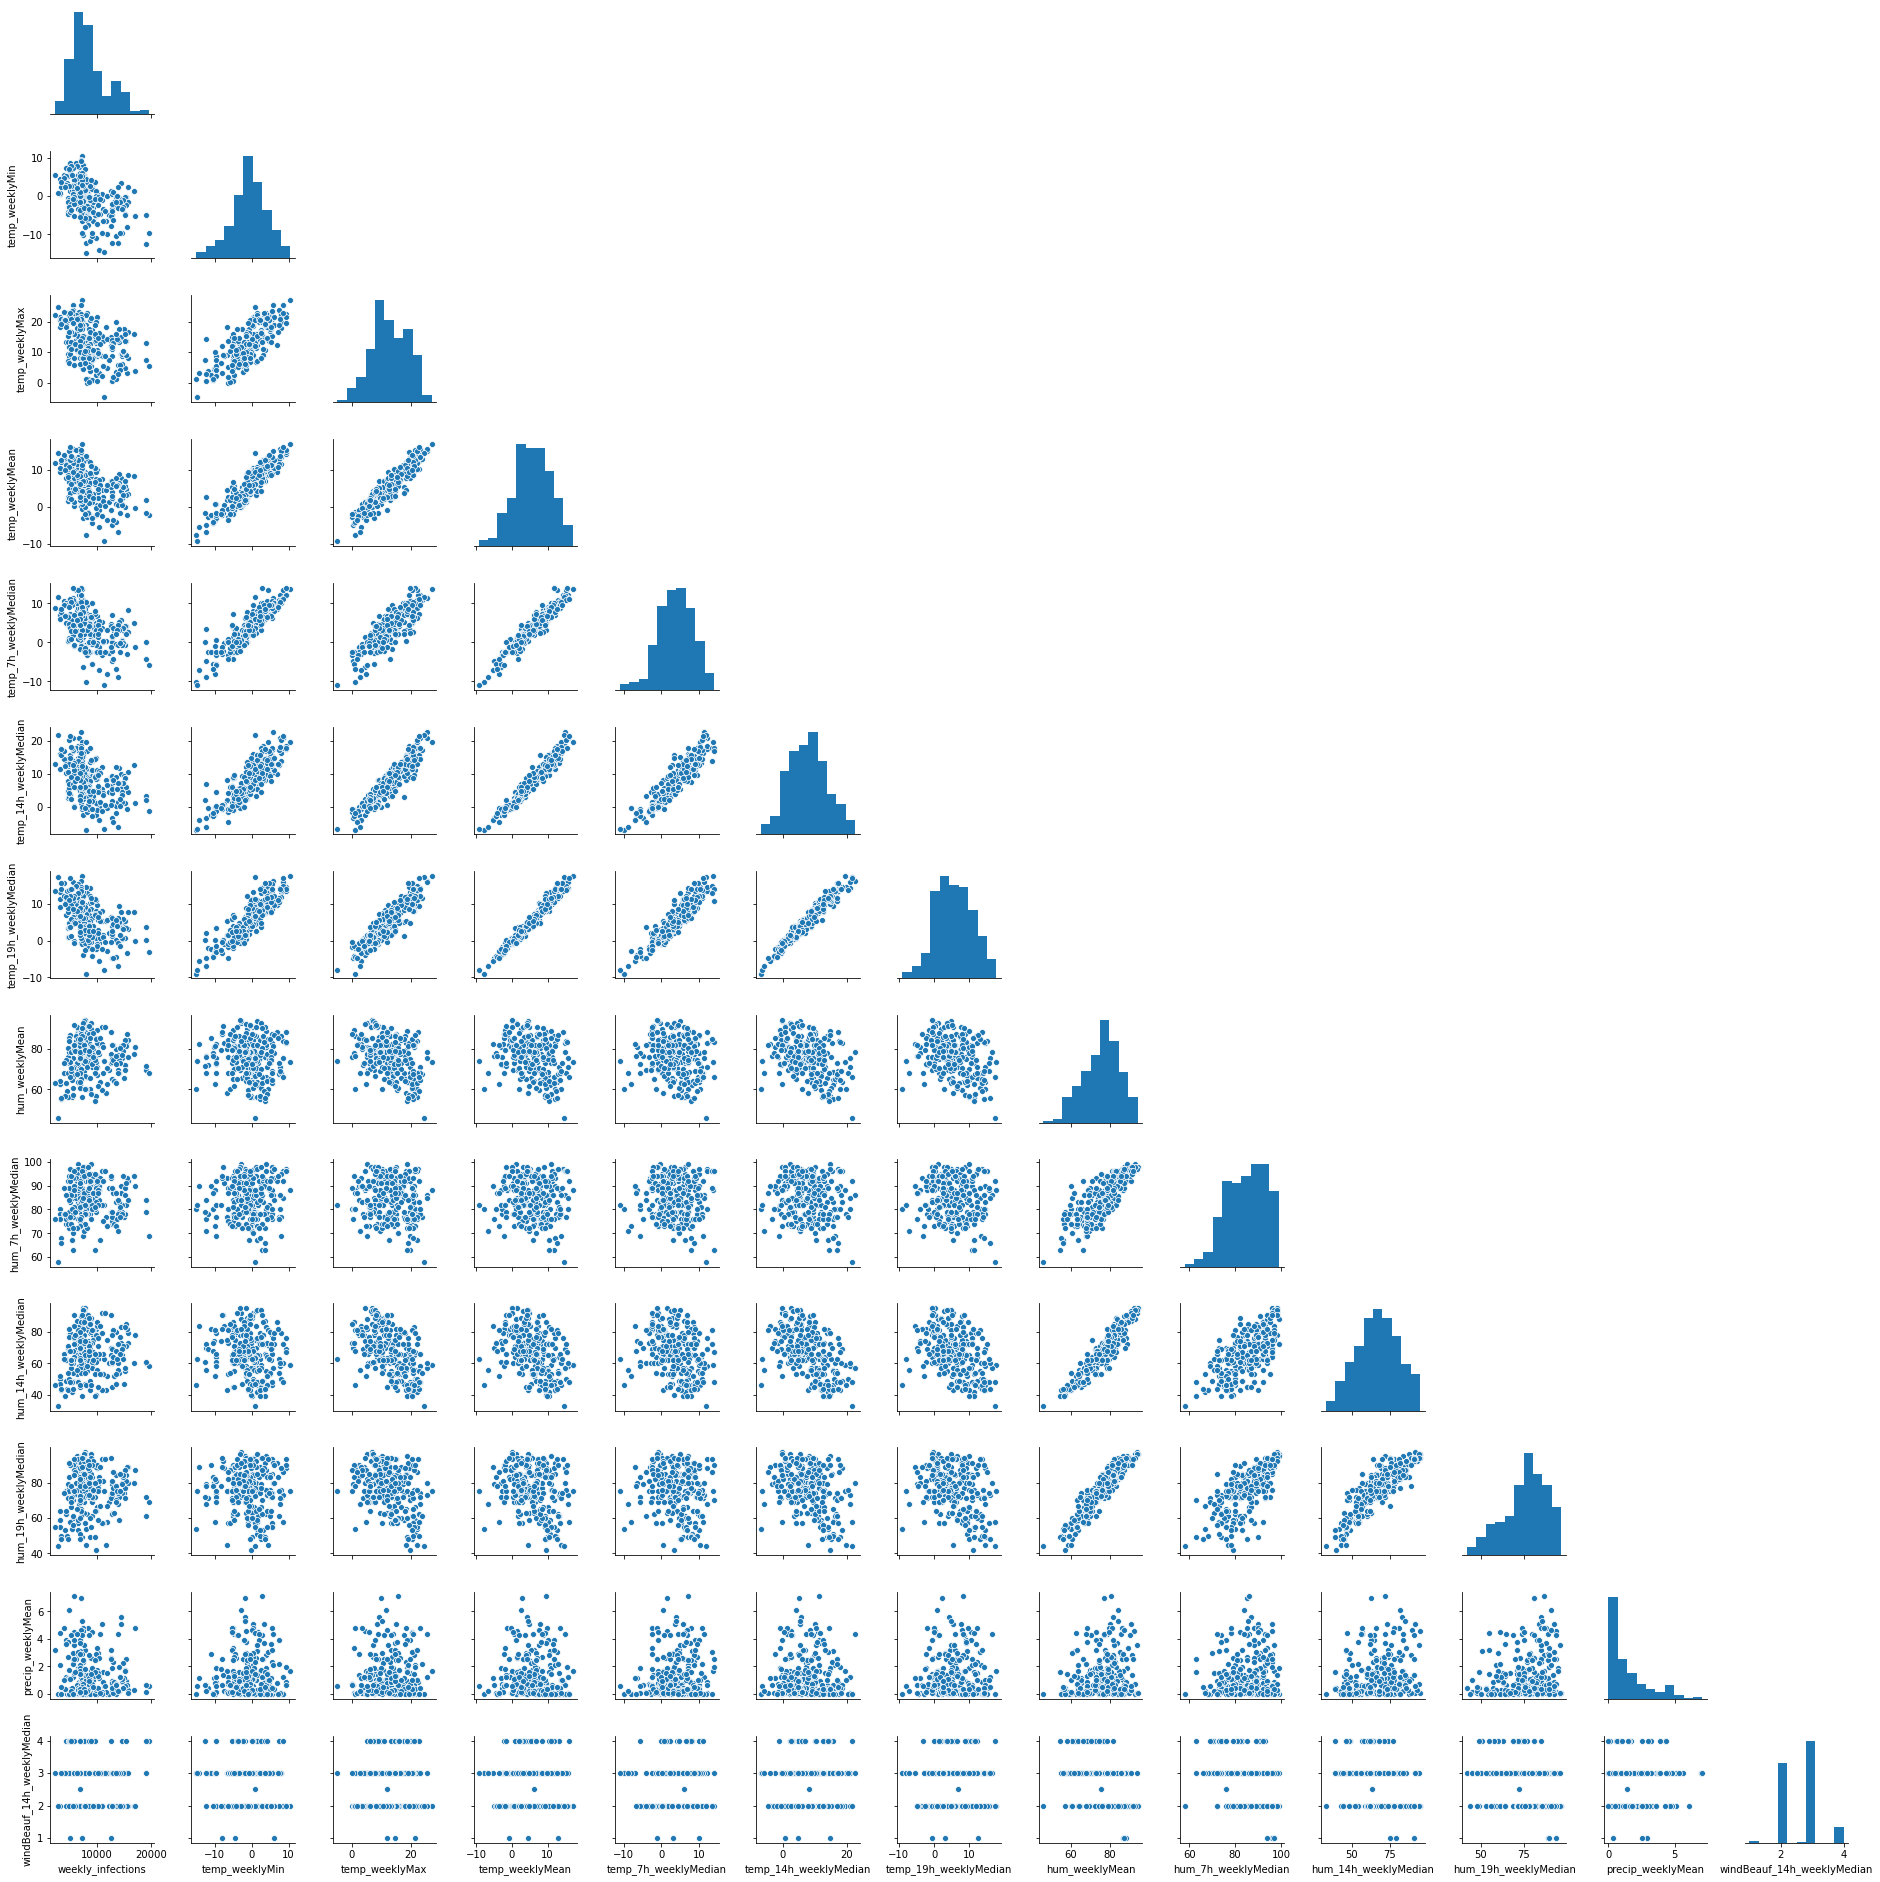

In [32]:
sns.pairplot(data_merged, height=2, corner=True)
plt.show()

Our previous observations can be seen more clearly in the above scatterplot matrix. Temperature values are negativly correlated. So the smaller the temperature the higher the number of influenza cases. 
For the other features we see that there is no correlation with the target variable. We can also see that the wind values have only 5 weekly median values.

In [33]:
data_merged.windBeauf_14h_weeklyMedian.unique()

array([3. , 2. , 4. , 1. , 2.5])

Next we have a look at how different features differ overt time. We have to know for the following visualizations that we have no information over all weeks but measures were only taken from October for some months over the flue season.

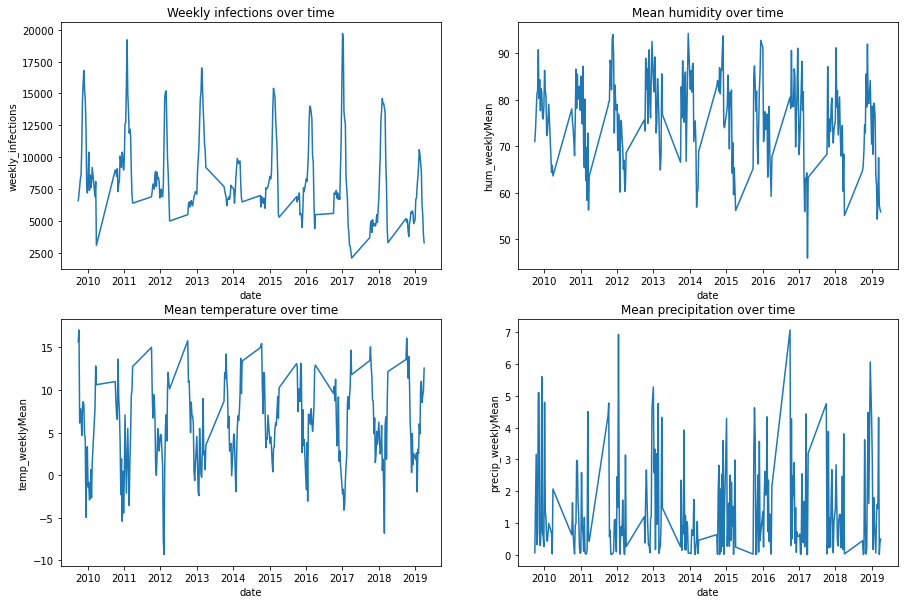

In [34]:
# prepare data for visualization
# create date from iso calendar
df = data_merged.copy().reset_index()
def create_date(row):
    return date.fromisocalendar(int(row.year), int(row.week), 1)
df['date'] = df.apply(create_date, axis=1)
df = df.set_index('date')

# Set up the matplotlib figure
f, axs = plt.subplots(2, 2, figsize=(15, 10))

# create lineplot for weekly infections
axs[0, 0].set_title('Weekly infections over time')
sns.lineplot(data=df, x=df.index, y='weekly_infections', ax=axs[0, 0])

# create lineplot for temperature
axs[1, 0].set_title('Mean temperature over time')
sns.lineplot(data=df, x=df.index, y='temp_weeklyMean', ax=axs[1, 0])

# create lineplot for humidity
axs[0, 1].set_title('Mean humidity over time')
sns.lineplot(data=df, x=df.index, y='hum_weeklyMean', ax=axs[0, 1])

# create lineplot for precipitation
axs[1, 1].set_title('Mean precipitation over time')
sns.lineplot(data=df, x=df.index, y='precip_weeklyMean', ax=axs[1, 1])

plt.show()

The above Figure shows us that we can see a seasonal difference in the height of influenza infections. Also the seasonal changes in humidity and temperature can be seen. The precipitation on the other side fluctuates a lot.

To better see the relation between humidity, temperature and infections we scale them by using a StandardScaler and plot them in one figure.

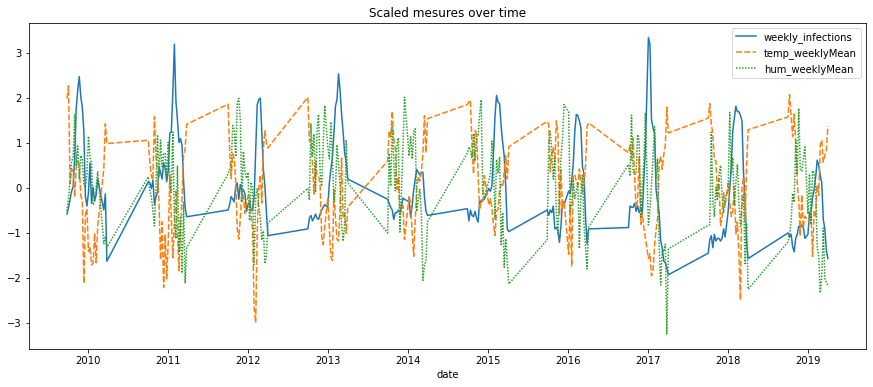

In [35]:
# scale data and only select infections, temperature and humidity
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)
df_scaled = df_scaled[['weekly_infections', 'temp_weeklyMean', 'hum_weeklyMean']]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('Scaled mesures over time')
sns.lineplot(data=df_scaled)
plt.show()

The above figure show us that after a period of cold weather the influenza infections usually rise. Also the humidity seems to fall when the infections rise.

#### Findings 
Summarize your findings.

First, we inspected the correlation of the merged dataset especially the correlation with the target variable. Only the temperature values are moderately correlated (-0.39 to - 0.45) with the influenza infections. For humidity values only a low degree of correlation can be measured (0.03 to 0.10). Also the precipitation (-0.07) and the wind measures (0.04) have only a low correlation with the target variable. As is clear a high correlation within the groups of features (temperature, humidity) can be observed.

Second, we got a better understanding of the correlations between features and also the distribution of features with the pairplot. This strengthens the observations we made before in the heatmap. We clearly see that as temperature decreases the number of infections rise. 
Also most of the values are normally distributed. Only precipitation has mainly very low values and the wind measures have only 5 unique medians for all observations.

Last, we tried to observe different features and how they change over time. There we can clearly see the seasonal differences in temperature and infections. The humidity and the precipitation are not so clear here because we have to take into account that the measures are not continues but the weeks over the summer are always missing.
In the scaled figure we can observe that after a period of cold weather the influenza infections start to rise. Also the humidity seems to fall before the infections rise but this maybe can also be explained by the temperature.

## Task 7: Influenza prediction model 

Build a model to predict the number of influenza incidents for the first part of the 2019/<span style="color:red">2020</span> Influenza season (`influenza_predict.csv`) based on data of previous years using `sklearn`. 

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure your results are reproducible
 - Don't hesitate to go back to previous steps if you notice any data quality issues
 - If your chosen algorithm has specific parameters, explore their effect with different settings using 10-fold cross-validation
 - Experiment with different training/test splits
 - If appropriate, try different scaling approaches (min/max, z-score,..).
 - How good does your model fit when you evaluate it with the test data set?
 - How good are your predictions when you use the data entries in `influenza.csv` for 2019 as a validation set?
 - Present your results (e.g. by plotting predicted against true values)
 

In [36]:
# set matriculation number as seed
np.random.seed(matr_nr)

First we need to prepare our data and split it in X (data without target variable) and y (target) and load our test dataset and apply the same transformations to it as we did for our training dataset.

In [37]:
# training data
y = data_merged['weekly_infections']
X = data_merged.drop('weekly_infections', axis=1)

In [38]:
# load test data
def load_test_set():
    DATA_FILE = './data/influenza/influenza_predict.csv'

    influenza_data = pd.read_csv(DATA_FILE)
    
    # same transormations as for orignial data
    influenza_data['week'] = influenza_data['Kalenderwoche'].transform(lambda x: int(x.split('.')[0]))
    influenza_data = influenza_data.rename(columns={'Neuerkrankungen pro Woche': 'weekly_infections', 'Jahr': 'year'})
    influenza_data = influenza_data.loc[:,['year', 'week', 'weekly_infections']]
    influenza_data = influenza_data.dropna()
    influenza_data = influenza_data.set_index(['year', 'week'])
    
    # same merge on data
    merged_data = influenza_data.merge(data_weather_weekly, how='left', left_index=True, right_index=True)
    y = merged_data['weekly_infections']
    X = merged_data.drop('weekly_infections', axis=1)
    
    return X, y

X_test, y_test = load_test_set()

assert X_test.shape == (13, 12) and y_test.shape == (13,)

In [39]:
# split into training and validation set
# without shuffling to predict data in the future
# test size is 1/10 so we try to predict the last year
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/10, shuffle=False)

Now we create our first base model. We decided to use a simple LinearRegression model for this.

In [40]:
# base model linear regression
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression())
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

-0.9902870605997931

The R² score is negative which mean our model is very bad at predicting the validation dataset.

Next we test a different train test split (20% test data)

In [41]:
# test different train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
# base model linear regression
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression())
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.016319008634496424

The R² score is at least positive with a larger validation dataset.

Next, we inspect the effect of feature selection on our base model.

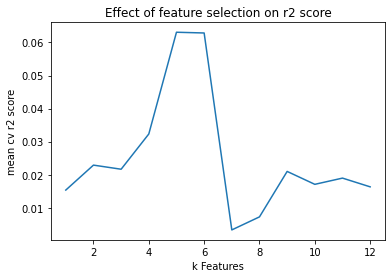

In [42]:
# effect of feature selection
scores = []
k_range = range(1, 13)
for k in k_range:
    pipe = make_pipeline(
        StandardScaler(),
        SelectKBest(score_func=f_regression, k=k),
        LinearRegression())
    pipe.fit(X_train, y_train)
    score = pipe.score(X_val, y_val)
    scores.append(score)
plt.plot(k_range, scores)
plt.xlabel("k Features")
plt.ylabel("mean cv r2 score")
plt.title('Effect of feature selection on r2 score')
plt.show()

The figure above shows us that the linear regression model performs best with only 5 or 6 features. Although the R² score is still very low.

Next, we try a different regression model. We decided to use a Random Forest regressor because they usually have a good performance.

In [43]:
# base model linear regression
pipe = make_pipeline(RandomForestRegressor())
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

-0.1318184836932681

The model without any preprocessing steps and hyperparameter tuning performs worse than our linear regression model.

We try to improve the model by applying a grid search for different parameters.

In [44]:
# apply grid search to an estimator
def grid_search(estimator, X, y, param_grid):
    
    search = GridSearchCV(estimator=estimator,
                          param_grid=param_grid,
                          cv=TimeSeriesSplit(n_splits=10), 
                          refit=True, 
                          scoring=make_scorer(r2_score), 
                          n_jobs=-1)
    fitted = search.fit(X, y)
    
    print(f'best score: {search.best_score_}')
    print(f'best parameters: {search.best_params_}') 
    
    return fitted.best_estimator_

In [45]:
# base model linear regression
pipe = make_pipeline(
    SelectKBest(score_func=f_regression, k=k),
    RandomForestRegressor(random_state=matr_nr))
param_grid = {
    'randomforestregressor__n_estimators': range(10, 101, 10),
    'randomforestregressor__max_depth' : [4, 8, 16, 32],
    'randomforestregressor__min_samples_split': [0.1, 0.6, 1.0],
    'randomforestregressor__max_features': [0, 3, 6],
    'randomforestregressor__min_samples_leaf': [2, 6, 50, 100]
}
random_forest = grid_search(pipe, X, y, param_grid)

best score: -0.08045896808523319
best parameters: {'randomforestregressor__max_depth': 4, 'randomforestregressor__max_features': 3, 'randomforestregressor__min_samples_leaf': 6, 'randomforestregressor__min_samples_split': 0.1, 'randomforestregressor__n_estimators': 10}


As we see by the above output the grid search was not able to improve the performance of the random forest regressor by much.

Now we test our model first on the validation data and afterwards on the test data.

In [46]:
# evaluate on validation set
random_forest.fit(X_train, y_train)
random_forest.score(X_val, y_val)

-0.028865036447838

In [47]:
# evaluate on test set
random_forest.fit(X, y)
random_forest.score(X_test, y_test)

-16.592376066629754

The R² score of the model is even worse and we were not able to create a model that is able to predict the influenza data.

In [48]:
linear_regression = make_pipeline(
    SelectKBest(score_func=f_regression, k=5),
    LinearRegression())
pipe.fit(X, y)
pipe.score(X_test, y_test)

-13.630263553113553

Our best baseline linear regression model is also very bad at predicting the test set but performs slightly better than the random forest model.

#### Approach and algorithm
Motivate your approach and choice of algorithm in the cell below

We decided to evaluate a linear regression model as our baseline model to ensure that our second algorithm performs at least better than this baseline.

The main algorithm we evaluated was a random forest regressor which we decided on because it is a quite robust algorithm and great for obtaining non-linear relationships between input features and the target variable.

We used a train_test_split without shuffling to create our training and validation datasets because we want to evaluate the model on unseen future data.

A StandardScaler is used at first but it does not have any effect on linear regression or on a random forest model. Scaling would just change the coefficients for the linear regression but not the score and random forest is not sensitive on the variance in the data. Thus, the effect of other scaling methods are not evaluated.

We also tested the effect of feature selection on the performance of the linear regression as we before saw that the correlation with the target variable is very low for most of the features (except temperature).

Last we want to improve our random forest model by tuning the hyperparameters. For this we use a grid search and a 10-fold-cross-validation. TimeSeriesSplit is used to ensure that we predict future data.

#### Findings 
Summarize your findings and lessons learned.

Our baseline model and the randam forest regressor are both not able to predict the number influenza infections. For both models and for the training and validation set the R² score is always below 0.

For the last random forest regressor the feature selection had no impact as the best model determined by GridSearch has a max_depth of only 4.

There is only a correlation between the temperatures and the target variable. All temperature features are highly correlated with each other because the temperature in one week is somewhat similar. Other weather features have almost no correlation with the target variable. Thus, we are in a way tying to predict one value (number of infections) from another (temperature).

We further have seen that we have a period of low temperatures and only after some time the infections rise. This makes it hard for our models to predict the target value if not the current temperature is important but the previous weeks. To account for this we would have to transform the data in a different way and store the temperatures for previous weeks.

How to preprocess data and transform it to make it usable was one of the main lessons learned in this exercise for me. Especially handling missing values and outliers was interesting as there exist a vast amount of different approaches. 
The prediction model part was rather disappointing as the performance of the models is this bad.